In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#import os
#print(os.listdir("../input"))

In [2]:
dTrain = pd.read_csv('train.csv')
dTest = pd.read_csv('test.csv')

In [3]:
def process_dataset(df):
    #Fill NA & change 'Sex' into binary variables
    df['Sex'] = df['Sex'].map({'male':0,'female':1})
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Embarked'].fillna('S', inplace=True)
    
    #Get dummies for Pclass
    Pclass = pd.get_dummies(df['Pclass'],prefix='Class')
    df = df.join(Pclass)
    
    #Get dummies for Embarked
    Emb = pd.get_dummies(df['Embarked'],prefix='Embarked')
    df = df.join(Emb)
    
    #Turn 'Name' and 'Cabin' into dummies
    Name = df['Name'].str.split(' ', expand=True)[1]
    Title = pd.get_dummies(Name,prefix='Title')
    df = df.join(Title[['Title_Mr.', 'Title_Mrs.']])
        
    Cabin = df['Cabin'].str[0]
    Cab = pd.get_dummies(Cabin,prefix='Deck')
    df = df.join(Cab)
     
    #Drop unnecessary columns
    df.drop(['Ticket', 'Pclass','PassengerId','Embarked_S', 'Embarked', 'Name', 'Cabin'], axis=1, inplace=True)
        
    return df

In [8]:
dTrain_edit0 = process_dataset(dTrain)
dTest_edit0 = process_dataset(dTest)

dTrain_edit = dTrain_edit0[['Fare','Title_Mr.','Title_Mrs.','Class_1','Class_3']]
dTest_edit = dTest_edit0[['Fare','Title_Mr.','Title_Mrs.','Class_1','Class_3']]

dTest_edit = process_dataset(dTest)


#Cross-validation purpose
#X = dTrain_edit.drop(['Survived','Deck_T'], axis=1)
X = dTrain_edit
y = dTrain_edit0['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = MinMaxScaler()
X_train_std, X_test_std = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

In [9]:
#Identify top 5 features
Corr = dTrain_edit.corr()
Corr_sorted = Corr.iloc[:,0].abs().sort_values(ascending=False)
Corr_sorted[2:7]

#sns.heatmap

Class_3       0.413333
Title_Mr.     0.175151
Title_Mrs.    0.104036
Name: Fare, dtype: float64

In [11]:
#Model test
def run_alg(alg):
    alg.fit(X_train_std, y_train)
    y_pred = alg.predict(X_test_std)
    acc, f1 = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)
    return acc, f1

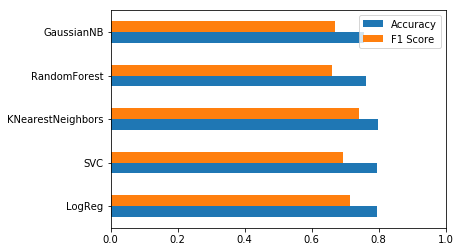

In [12]:
algs = [LogisticRegression(solver='lbfgs'),SVC(gamma='auto'),KNeighborsClassifier(), RandomForestClassifier(n_estimators=100), GaussianNB()]
algs_name = ['LogReg', 'SVC', 'KNearestNeighbors','RandomForest','GaussianNB']
result_table = pd.DataFrame(index = algs_name, columns=['Accuracy','F1 Score'])

j=0 #iterator
for alg in algs:
    acc, f1 = run_alg(alg)
    result_table.iloc[j,0] = acc
    result_table.iloc[j,1] = f1
    j+=1
    
result_table.plot(kind='barh', xlim=(0,1))

Max value is: Accuracy    0.820896
F1 Score    0.761905
dtype: float64  for n= 23


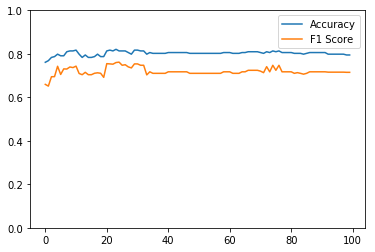

In [13]:
#Deep-dive in KNN
knn_result_table = pd.DataFrame(index=range(100), columns=['Accuracy','F1 Score'])

j=0 #iterator
for n in range(1,101):
    knn = KNeighborsClassifier(n_neighbors=n)
    acc, f1 = run_alg(knn)
    knn_result_table.iloc[j,0] = acc
    knn_result_table.iloc[j,1] = f1
    j+=1
    
knn_result_table.plot(kind='line', ylim=(0,1))
print('Max value is:', knn_result_table.max(), ' for n=', knn_result_table['Accuracy'].astype(float).idxmax(skipna=True))

In [ ]:
#Prepare for submission
#X_test = dTest_edit
#X_std, X_test_std = scaler.fit_transform(X), scaler.fit_transform(X_test)

#knn = KNeighborsClassifier(n_neighbors=6)
#knn.fit(X_std, y)
#result_sub = knn.predict(X_test_std)
#submission = pd.DataFrame(columns = ['PassengerId', 'Survived'])
#submission.PassengerId = dTest.PassengerId
#submission.Survived = result_sub

#submission.head()

In [ ]:
#submission.to_csv('submission2.csv',index=False)

Max value is: Accuracy    0.794776
F1 Score    0.715026
dtype: float64  for C= 0.1


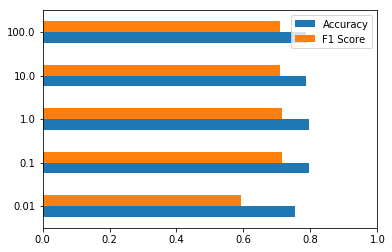

In [14]:
#Deep-dive in Logistics Regression
C = [0.01, 0.1, 1, 10, 100]
LogReg_result_table = pd.DataFrame(index=C, columns=['Accuracy', 'F1 Score'])

j=0 #iterator
for c in C:
    LogReg = LogisticRegression(C=c)
    acc, f1 = run_alg(LogReg)
    LogReg_result_table.iloc[j,0] = acc
    LogReg_result_table.iloc[j,1] = f1
    j+=1
    
LogReg_result_table.plot(kind='barh', xlim=(0,1))
print('Max value is:', LogReg_result_table.max(), ' for C=', LogReg_result_table['Accuracy'].astype(float).idxmax(skipna=True))

Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Class_1       0
Class_2       0
Class_3       0
Embarked_C    0
Embarked_Q    0
Title_Mr.     0
Title_Mrs.    0
Deck_A        0
Deck_B        0
Deck_C        0
Deck_D        0
Deck_E        0
Deck_F        0
Deck_G        0
dtype: int64